In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from numpngw import write_apng
from IPython.display import Image
from pendulum import *

  0%|          | 0/100 [00:00<?, ?it/s]

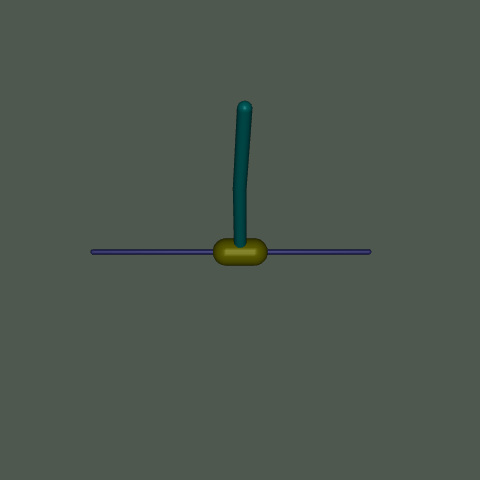

In [3]:
env = gym.make('InvertedDoublePendulum-v4', render_mode='rgb_array')
env.reset()

frames = []  # frames to create animated png
frames.append(env.render())
for i in tqdm(range(100)):
    action = env.action_space.sample()
    s = env.step(action)
    img = env.render()
    frames.append(img)

write_apng("cartpole_example.png", frames, delay=10)
Image(filename="cartpole_example.png")


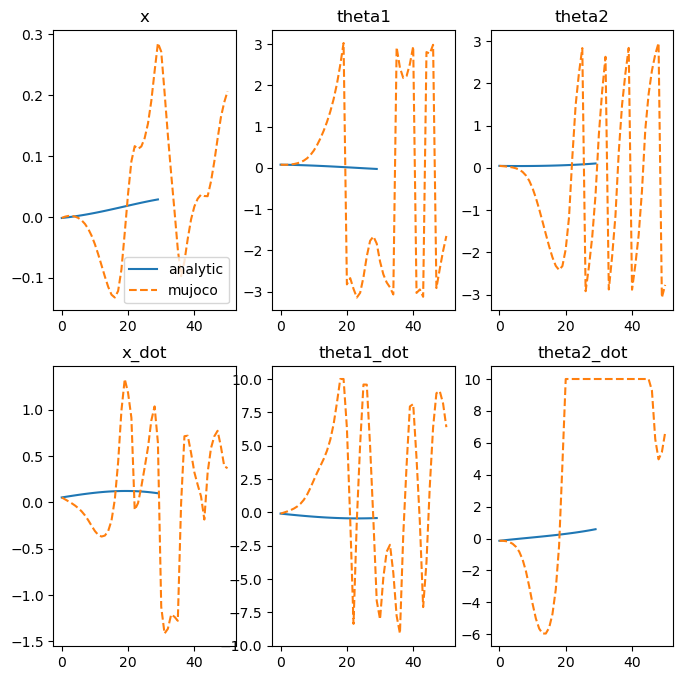

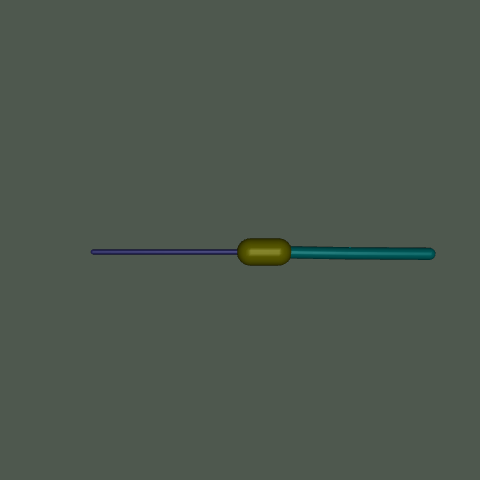

In [51]:
frames = []  # frames to create animated png
frames.append(env.render())
## Let's test to see if your analytic dynamics matches the simulator

# first let's generate a random control sequence
T = 50
#control_sequence = np.random.randn(T, 1)
control_sequence = np.zeros((T, 1))
#start_state = np.array([1, 0.25, 0, 0])

# We use the simulator to simulate a trajectory
env = gym.make('InvertedDoublePendulum-v4', render_mode='rgb_array')
start_state,_ = env.reset()
#env.reset(start_state)

states_mujoco = np.zeros((T+1, 8))
states_mujoco[0] = start_state[:8]

for t in range(T):
    full_states_mujoco,_,_,_,_ = env.step(control_sequence[t])
    states_mujoco[t+1] = full_states_mujoco[:8]
    img = env.render()
    frames.append(img)

# Now we will use your analytic dynamics to simulate a trajectory
# Need an extra 1 which is the batch dimension (T x B x 4)
states_analytic = np.zeros((T+1, 1, 6))
states_analytic[0] = change_of_coords(start_state) # torch.from_numpy(start_state).reshape(1, 4)
for t in range(T):
    #current_state = states_analytic[t]
    #current_control = #torch.from_numpy(control_sequence[t]).reshape(1, 1)  # add batch dimension to control
    states_analytic[t +1] = dynamics_analytic(states_analytic[t], control_sequence[t])
    #print(dynamics_analytic(states_analytic[t], control_sequence[t]).shape)

# convert back to numpy for plotting
states_analytic = states_analytic.reshape(T+1, 6)

# convert mujoco states to analytic states
states_mujoco_transformed = T_change_of_coords(states_mujoco)

# Plot and compare - They should be indistinguishable
fig, axes = plt.subplots(2, 3, figsize=(8, 8))

axes[0][0].plot(states_analytic[:30, 0], label='analytic')
axes[0][0].plot(states_mujoco_transformed[:, 0], '--', label='mujoco')
axes[0][0].title.set_text('x')

axes[0][1].plot(states_analytic[:30, 1])
axes[0][1].plot(states_mujoco_transformed[:, 1], '--')
axes[0][1].title.set_text('theta1')

axes[0][2].plot(states_analytic[:30, 2])
axes[0][2].plot(states_mujoco_transformed[:, 2], '--')
axes[0][2].title.set_text('theta2')

axes[1][0].plot(states_analytic[:30, 3])
axes[1][0].plot(states_mujoco_transformed[:, 3], '--')
axes[1][0].title.set_text('x_dot')

axes[1][1].plot(states_analytic[:30, 4])
axes[1][1].plot(states_mujoco_transformed[:, 4], '--')
axes[1][1].title.set_text('theta1_dot')

axes[1][2].plot(states_analytic[:30, 5])
axes[1][2].plot(states_mujoco_transformed[:, 5], '--')
axes[1][2].title.set_text('theta2_dot')

axes[0][0].legend()
plt.show()

write_apng("cartpole_example.png", frames, delay=10)
Image(filename="cartpole_example.png")


In [59]:
# Get properties of the pendulum

import mujoco
env = gym.make('InvertedDoublePendulum-v4', render_mode='rgb_array')
env.reset()
m = env.model.body_mass
l = env.model.geom_size
lcm = env.model.body_ipos
print(m)
print(l)
print(lcm)

print(mujoco.mj_name2id(env.model, 1, 'cart'))
print(mujoco.mj_name2id(env.model, 1, 'pole'))
print(mujoco.mj_name2id(env.model, 1, 'pole2'))

print(env.model.dof_damping)
print(env.model.opt.timestep)
print(env.model.opt.gravity)

[ 0.         10.47197551  4.19873858  4.19873858]
[[4.0e+01 4.0e+01 4.0e+01]
 [2.0e-02 1.0e+00 0.0e+00]
 [1.0e-01 1.0e-01 0.0e+00]
 [4.5e-02 3.0e-01 0.0e+00]
 [4.5e-02 3.0e-01 0.0e+00]]
[[0.  0.  0. ]
 [0.  0.  0. ]
 [0.  0.  0.3]
 [0.  0.  0.3]]
1
2
3
[0.05 0.05 0.05]
0.01
[ 1.00e-05  0.00e+00 -9.81e+00]


In [9]:
def get_methods(object, spacing=20):
  methodList = []
  for method_name in dir(object):
    try:
        if callable(getattr(object, method_name)):
            methodList.append(str(method_name))
    except Exception:
        methodList.append(str(method_name))
  processFunc = (lambda s: ' '.join(s.split())) or (lambda s: s)
  for method in methodList:
    try:
        print(str(method.ljust(spacing)) + ' ' +
              processFunc(str(getattr(object, method).__doc__)[0:90]))
    except Exception:
        print(method.ljust(spacing) + ' ' + ' getattr() failed')
